256
[1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375, 1033.59375,

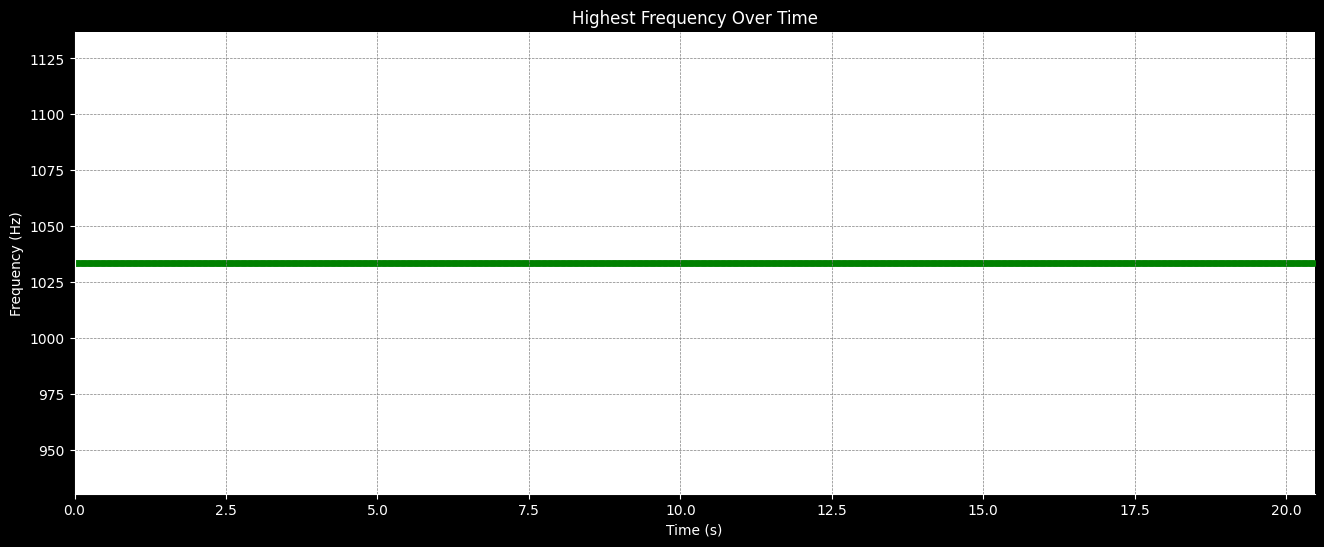

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import struct

def process_wav_fft(file_path, duration):
    """
    Process a WAV file, calculate FFTs for segments of the audio,
    and store them in an array.

    Args:
        file_path (str): Path to the WAV file.
        duration (float): Duration in seconds for each FFT segment.

    Returns:
        np.ndarray: 2D array where each row is the magnitude of an FFT.
    """
    # Open the WAV file
    with wave.open(file_path, 'r') as wav_file:
        # Extract basic information
        num_channels = wav_file.getnchannels()
        sample_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()

        # Calculate number of samples per segment based on duration
        samples_per_segment = int(sample_rate * duration)

        # Read all frames from the WAV file
        frames = wav_file.readframes(num_frames)
        audio_data = np.array(struct.unpack(f"{num_frames * num_channels}h", frames))

        # If the WAV file is stereo, average channels to make it mono
        if num_channels > 1:
            audio_data = audio_data.reshape(-1, num_channels).mean(axis=1)

        # Calculate FFT for each segment
        ffts = []
        for start in range(0, len(audio_data), samples_per_segment):
            segment = audio_data[start:start + samples_per_segment]

            # Zero-pad if the segment is shorter than samples_per_segment
            if len(segment) < samples_per_segment:
                segment = np.pad(segment, (0, samples_per_segment - len(segment)))

            # Perform FFT and store magnitude
            fft_result = np.fft.fft(segment)
            ffts.append(np.abs(fft_result[:len(fft_result) // 2]))  # Keep positive frequencies

        return np.array(ffts)

def plot_ffts(ffts, min_bin=None, max_bin=None, rows_per_fft=1, output_file="fft_plot.png"):
    """
    Plot FFTs as a grayscale image, with an option to zoom in on specific bins,
    allow each FFT to span multiple rows of pixels, and save the plot to a PNG file.

    Args:
        ffts (np.ndarray): 2D array where each row is an FFT's magnitude spectrum.
        min_bin (int): Minimum bin index to include in the plot (default: None, start from 0).
        max_bin (int): Maximum bin index to include in the plot (default: None, go to the last bin).
        rows_per_fft (int): Number of rows each FFT should span in the plot.
        output_file (str): File path to save the plot as a PNG.
    """
    # Apply bin limits
    if min_bin is None:
        min_bin = 0
    if max_bin is None or max_bin > ffts.shape[1]:
        max_bin = ffts.shape[1]

    zoomed_ffts = ffts[:, min_bin:max_bin]

    # Normalize FFT values for color mapping
    fft_min = np.min(zoomed_ffts)
    fft_max = np.max(zoomed_ffts)
    normalized_ffts = (zoomed_ffts - fft_min) / (fft_max - fft_min)  # Normalize to [0, 1]

    # Expand each FFT to span multiple rows
    expanded_ffts = np.repeat(normalized_ffts, rows_per_fft, axis=0)

    # Create the plot
    plt.figure(figsize=(10, 60))
    plt.imshow(expanded_ffts, aspect='auto', cmap='Greys', origin='lower')
    plt.colorbar(label='Normalized Magnitude')
    plt.title(f'FFT Magnitude Spectrum Visualization (Bins {min_bin} to {max_bin})')
    plt.xlabel('Frequency Bin')
    plt.ylabel('FFT Segment (scaled by rows)')

    # Save the plot to a file
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved as {output_file}")

    # Display the plot
    plt.show()


def find_highest_frequency(file_path, segment_duration):
    """
    Process a WAV file and determine the highest frequency in each segment.

    Args:
        file_path (str): Path to the WAV file.
        segment_duration (float): Duration of each segment in seconds.

    Returns:
        list: List of highest frequencies for each segment.
    """
    # Open the WAV file
    with wave.open(file_path, 'r') as wav_file:
        # Extract basic information
        num_channels = wav_file.getnchannels()
        sample_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()

        # Calculate number of samples per segment
        samples_per_segment = int(sample_rate * segment_duration)
        print(samples_per_segment)
        # Read all frames from the WAV file
        frames = wav_file.readframes(num_frames)
        audio_data = np.array(struct.unpack(f"{num_frames * num_channels}h", frames))

        # If the WAV file is stereo, average channels to make it mono
        if num_channels > 1:
            audio_data = audio_data.reshape(-1, num_channels).mean(axis=1)

        # Initialize list to store highest frequencies
        highest_frequencies = []

        # Process each segment
        for start in range(0, len(audio_data), samples_per_segment):
            segment = audio_data[start:start + samples_per_segment]

            # Zero-pad if the segment is shorter than samples_per_segment
            if len(segment) < samples_per_segment:
                segment = np.pad(segment, (0, samples_per_segment - len(segment)))

            # Perform FFT
            fft_result = np.fft.fft(segment)
            fft_magnitude = np.abs(fft_result[:len(fft_result) // 2])  # Keep positive frequencies
            fft_freqs = np.fft.fftfreq(len(segment), d=1 / sample_rate)[:len(fft_result) // 2]

            # Find the frequency with the maximum magnitude
            max_index = np.argmax(fft_magnitude)
            highest_frequency = fft_freqs[max_index]
            highest_frequencies.append(highest_frequency)

        return highest_frequencies

# def plot_highest_frequencies(highest_frequencies, segment_duration):
#     """
#     Plot the highest frequencies over time with a green line on a black background.
#
#     Args:
#         highest_frequencies (list): List of highest frequencies.
#         segment_duration (float): Duration of each segment in seconds.
#     """
#     # Create time axis
#     time_axis = np.arange(len(highest_frequencies)) * segment_duration
#
#     # Create the plot
#     plt.figure(figsize=(10, 6), facecolor='black')
#     plt.plot(time_axis, highest_frequencies, color='green', linewidth=1.5)
#     plt.title('Highest Frequency Over Time', color='white')
#     plt.xlabel('Time (s)', color='white')
#     plt.ylabel('Frequency (Hz)', color='white')
#     plt.grid(color='gray', linestyle='--', linewidth=0.5)
#     plt.xlim([0, max(time_axis)])
#     plt.ylim([min(highest_frequencies) * 0.9, max(highest_frequencies) * 1.1])
#     plt.gca().spines['bottom'].set_color('white')
#     plt.gca().spines['left'].set_color('white')
#     plt.gca().tick_params(axis='x', colors='white')
#     plt.gca().tick_params(axis='y', colors='white')
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#
#     # Show the plot
#     plt.show()


def plot_highest_frequencies(highest_frequencies, segment_duration):
    """
    Plot the highest frequencies over time as dots (not connected)
    with a green color on a black background.

    Args:
        highest_frequencies (list): List of highest frequencies.
        segment_duration (float): Duration of each segment in seconds.
    """
    # Create time axis
    time_axis = np.arange(len(highest_frequencies)) * segment_duration

    # Create the plot
    plt.figure(figsize=(16, 6), facecolor='black')
    plt.scatter(time_axis, highest_frequencies, color='green', s=10)
    plt.title('Highest Frequency Over Time', color='white')
    plt.xlabel('Time (s)', color='white')
    plt.ylabel('Frequency (Hz)', color='white')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlim([0, max(time_axis)])
    plt.ylim([min(highest_frequencies) * 0.9, max(highest_frequencies) * 1.1])
    plt.gca().spines['bottom'].set_color('white')
    plt.gca().spines['left'].set_color('white')
    plt.gca().tick_params(axis='x', colors='white')
    plt.gca().tick_params(axis='y', colors='white')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Show the plot
    plt.show()












# Example usage
baud_rate = 50 # symbols per second, or Baud rate
duration = 1.0 / baud_rate
sample_rate = 44100
segment_duration = 2 ** 8 / sample_rate  # Duration for each segment in seconds
file_path = "tonic-z.wav"  # Path to your WAV file


ffts = process_wav_fft(file_path, duration)

# Print the FFTs
# for i, fft in enumerate(ffts):
#     print(f"FFT {i+1}: {fft}")

# Find the highest frequencies
highest_frequencies = find_highest_frequency(file_path, segment_duration)
print(highest_frequencies)
# Plot the highest frequencies
plot_highest_frequencies(highest_frequencies, segment_duration)


# # Plot the FFTs, save them to file
# plot_ffts(ffts, output_file="full_fft.png")
# plot_ffts(ffts, min_bin=0, max_bin=50, output_file="zoomed01_fft.png")
# plot_ffts(ffts, min_bin=15, max_bin=25, output_file="zoomed02_fft.png")






